<a href="https://colab.research.google.com/github/kra268/ChemCoder/blob/main/Random_forest_ChemCoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyTDC rdkit==2023.03.1 DeepChem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang')
data.get_data().head(2)

Downloading...
100%|██████████| 82.5k/82.5k [00:00<00:00, 917kiB/s]
Loading...
Done!


Drug_ID  \
0                                    (-)-epicatechin   
1  (2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...   

                                      Drug     Y  
0  Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2 -6.22  
1         C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C -3.86

In [3]:
data

In [4]:
drugs = data.get_data()
drugs

Drug_ID  \
0                                      (-)-epicatechin   
1    (2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...   
2                                              codeine   
3                                           creatinine   
4                                              danazol   
..                                                 ...   
905                        Capric acid (decanoic acid)   
906                                   Apometzgerin (2)   
907                                                  3   
908                                                51d   
909                                      Cycloheximide   

                                                  Drug         Y  
0              Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2 -6.220000  
1                     C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C -3.860000  
2    COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2... -4.090000  
3                                       CN1CC(=O)NC1=N -5.935409  
4    C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(... -4.840000  
..                                                 ...       ...  
905                                    CCCCCCCCCC(=O)O -4.680000  
906         COc1cc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc(O)c1OC -4.950000  
907  COC(=O)C[C@@H](C(=O)NN(Cc1ccc(/C=C\c2ccccc2)cc... -5.080000  
908  COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=... -5.300000  
909  C[C@H]1C[C@H](C)C(=O)[C@H]([C@H](O)CC2CC(=O)NC... -4.840000  

[910 rows x 3 columns]

In [5]:
import rdkit
rdkit.__version__

'2023.03.1'

In [6]:
import pandas as pd
import numpy as np
from rdkit.Chem import PandasTools, Descriptors, AllChem, AddHs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import deepchem as dc

In [7]:
# Let's add the structures to the dataframe
PandasTools.AddMoleculeColumnToFrame(drugs, 'Drug', 'Molecule')

In [8]:
drugs.sample(5)

Drug_ID                                               Drug  \
719    Levofloxacin  C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...   
50   hexapeptide 20  C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O...   
193              17  Cc1ccc(C(F)(F)CNc2ccc(C#N)c(CC(=O)NCCONC(=N)N)...   
834       3'-Cl BZT       CN1C2CC[C@@H]1CC(OC(c1ccccc1)c1cccc(Cl)c1)C2   
829        MEN14970  O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCOCC...   

            Y                                          Molecule  
719 -4.550000  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb15b0>  
50  -5.820000  <rdkit.Chem.rdchem.Mol object at 0x7f429cf56ea0>  
193 -6.188375  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa2dc0>  
834 -4.662271  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb4890>  
829 -4.930907  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb4660>

In [9]:
# There are no hydrogens in these structures. 
for idx, mol in enumerate(drugs.Molecule):
  drugs.Molecule[idx] = rdkit.Chem.AddHs(mol)

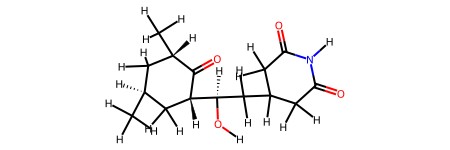

In [10]:
drugs.Molecule.iloc[-1]

In [11]:
# Lipinski's rule of 5:
# Poor absorption is likely if the molecule violates more than one of the following conditions:
# Molecular Weight <= 500 Da
# No. Hydrogen Bond Donors <= 10
# No. Hydrogen Bond Acceptors <= 5
# LogP <= 5

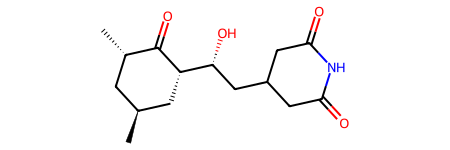

In [12]:
mol

In [13]:
# This chunk checks for Lipinski's rule of 5
MW = Descriptors.MolWt(mol)
HBA = Descriptors.NOCount(mol)
HBD = Descriptors.NHOHCount(mol)
LogP = Descriptors.MolLogP(mol)
conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
pass_ro5 = conditions.count(True) >= 3
print(pass_ro5)

True


In [14]:
def ro5_check(mol):
  MW = Descriptors.MolWt(mol)
  HBA = Descriptors.NOCount(mol)
  HBD = Descriptors.NHOHCount(mol)
  LogP = Descriptors.MolLogP(mol)
  conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
  pass_ro5 = conditions.count(True) >= 3
  return pass_ro5

In [15]:
# Let's make a new category to sort out all the drugs that violate the ro5
# If it follows ro5, the category = 1 else 0

In [16]:
int(True)

1

In [17]:
drugs['ro5'] = 0
for idx, mol in enumerate(drugs.Molecule):
  if ro5_check(mol) == True:
    drugs.ro5[idx] = 1 

In [18]:
drugs.sample(20)

Drug_ID  \
849        20E 22-methyl ether (4)   
708                             11   
151                     zidovudine   
377                   Penicillin G   
772                             2f   
503         20E 22-ethyl ether (5)   
237                     Ampicillin   
298            Netivudine (882C87)   
555                  Puerarin (34)   
38                  hexapeptide 01   
147             VLA-4 antagonist 4   
206                        881-13h   
609                      DB377 (4)   
417  EI analogue 101 (MDL 101,146)   
706                              8   
19                          EF5265   
11                          EF5170   
512             Rutaecarpine (RCP)   
831                              -   
331                      Tamoxifen   

                                                  Drug         Y  \
849  CO[C@H](CCC(C)(C)O)[C@](C)(O)[C@H]1CC[C@@]2(O)... -4.790000   
708  CNC(=O)[C@H](NC(=O)[C@](O)(Cc1ccccc1)CN(Cc1ccc... -5.470000   
151  Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(... -5.060000   
377  CC1(C)S[C@H]2[C@@H](NC(=O)Cc3ccccc3)C(=O)N2[C@... -5.869793   
772  COC(=O)c1c(Cl)cc(Cl)cc1-c1ccc([C@@H](C)NC(=O)C... -4.744728   
503  CCO[C@H](CCC(C)(C)O)[C@](C)(O)[C@H]1CC[C@@]2(O... -4.860000   
237      CC1(C)SC2C(NC(=O)C(N)c3ccccc3)C(=O)N2C1C(=O)O -6.070000   
298  CC#Cc1cn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(... -5.168745   
555  O=c1c(-c2ccc(O)cc2)coc2c(C3O[C@H](CO)[C@@H](O)... -6.398970   
38   C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@... -5.820000   
147  CN(C)C(=O)Oc1ccc(C[C@H](NC(=O)[C@H]2N(S(=O)(=O... -5.340000   
206  C[C@@H]1O[C@@H](c2ccc(Cl)cc2)OC[C@H]1NC(=O)Cc1... -4.992039   
609  CCO/N=C(\N)c1ccc(-c2ccc(-c3ccc(/C(N)=N/OCC)cc3... -5.229574   
417  CC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)c1c... -5.098455   
706  COCCNC(=O)[C@H](NC(=O)[C@](O)(Cc1ccccc1)CN(Cc1... -5.320000   
19   CCOCC(COCC)OC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=... -4.150000   
11    CCCCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1 -5.790000   
512              O=c1c2ccccc2nc2n1CCc1c-2[nH]c2ccccc12 -5.058253   
831                                          Oc1ccncc1 -4.108953   
331      CC/C(=C(/c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1 -4.322111   

                                             Molecule  ro5  
849  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb4eb0>    1  
708  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb1070>    0  
151  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa1af0>    1  
377  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa7e60>    1  
772  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb2c70>    1  
503  <rdkit.Chem.rdchem.Mol object at 0x7f429cfab5a0>    1  
237  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa4120>    1  
298  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa5bd0>    1  
555  <rdkit.Chem.rdchem.Mol object at 0x7f429cfaccf0>    1  
38   <rdkit.Chem.rdchem.Mol object at 0x7f429cf568f0>    1  
147  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa1930>    0  
206  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa3300>    1  
609  <rdkit.Chem.rdchem.Mol object at 0x7f429cfae490>    1  
417  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa9000>    1  
706  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb0f90>    0  
19   <rdkit.Chem.rdchem.Mol object at 0x7f429d28dee0>    0  
11   <rdkit.Chem.rdchem.Mol object at 0x7f429d6e6500>    1  
512  <rdkit.Chem.rdchem.Mol object at 0x7f429cfab990>    1  
831  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb46d0>    1  
331  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa6a40>    1

In [19]:
# Let's look at the descriptors
des_keys = Descriptors.CalcMolDescriptors(drugs.Molecule[0]).keys()

In [20]:
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [21]:
type(des_keys)

dict_keys

In [22]:
des = Descriptors.CalcMolDescriptors(drugs.Molecule[0])

In [23]:
len(des)

209

In [24]:
# Problem! It is difficult to calculate descriptors directly for the dataframe.
# Let's us use DeepChem

In [25]:
rdkit_featurizer = dc.feat.RDKitDescriptors()

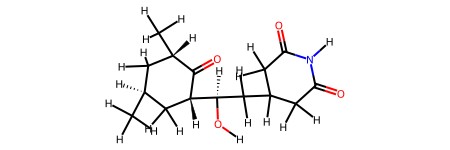

In [26]:
mol

In [27]:
rdkit_featurizer.featurize(mol)

array([[ 1.38516320e+01,  1.38516320e+01,  9.73220698e-01,
        -5.20893802e+00,  7.57155600e-01,  2.81352000e+02,
         2.58168000e+02,  2.81162708e+02,  1.12000000e+02,
         0.00000000e+00,  2.26338055e-01, -3.92368254e-01,
         3.92368254e-01,  2.26338055e-01,  1.55000000e+00,
         2.30000000e+00,  2.90000000e+00, -1.72683971e-16,
        -2.46769264e-01, -5.50314207e-17, -2.80808164e+00,
        -1.57050774e-16, -2.81461525e+00,  5.58036532e-18,
        -1.13431736e+00,  2.84389418e+00,  3.31501334e+00,
         1.21392725e+03,  3.50165079e+01,  3.25802068e+01,
         9.58020676e+00,  1.84414285e+01,  1.63691721e+01,
         5.01371018e+00,  3.50535682e+00,  3.50535682e+00,
         2.08667322e+00,  2.08667322e+00,  1.31143743e+00,
         1.31143743e+00, -1.23000000e+00,  2.84389418e+00,
         3.24011651e+00,  6.03773196e+00,  3.44974559e+00,
         1.51124489e+02,  5.10880819e+00,  5.78324495e+00,
         1.41184208e+00,  1.32455591e+01,  0.00000000e+0

In [28]:
type(rdkit_featurizer.featurize(mol))

numpy.ndarray

In [29]:
drugs['descriptors'] = drugs['Molecule'].apply(rdkit_featurizer.featurize)

In [30]:
drugs.sample(5)

Drug_ID                                               Drug  \
51        acetaminophen                                 CC(=O)Nc1ccc(O)cc1   
374         Epinephrine                              CNCC(O)c1ccc(O)c(O)c1   
239          Astemizole  COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2...   
680                   1  CN1C(=O)CC(N2CCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)c...   
531  Ac-Gly-Lys-Ala-NH2   CC(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(N)=O   

            Y                                          Molecule  ro5  \
51  -4.440000  <rdkit.Chem.rdchem.Mol object at 0x7f429d6b3530>    1   
374 -6.018865  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa7d10>    1   
239 -5.150000  <rdkit.Chem.rdchem.Mol object at 0x7f429cfa4200>    1   
680 -4.910000  <rdkit.Chem.rdchem.Mol object at 0x7f429cfb0430>    1   
531 -7.010000  <rdkit.Chem.rdchem.Mol object at 0x7f429cfac270>    1   

                                           descriptors  
51   [[11.465040233686066, 11.465040233686066, 0.20...  
374  [[8.076908541194255, 8.076908541194255, 0.6526...  
239  [[14.690161169336502, 14.690161169336502, 0.17...  
680  [[13.646667988510561, 13.646667988510561, 0.06...  
531  [[13.65166997354497, 13.65166997354497, 1.1755...

In [31]:
drugs.descriptors

0      [[8.856970427059712, 8.856970427059712, 0.8900...
1      [[12.563043391922376, 12.563043391922376, 1.03...
2      [[9.6092470946712, 9.6092470946712, 0.63608489...
3      [[11.160833333333333, 11.160833333333333, 0.03...
4      [[9.97418390967498, 9.97418390967498, 1.177787...
                             ...                        
905    [[11.447758335714909, 11.447758335714909, 2.34...
906    [[13.07531192803108, 13.07531192803108, 0.7630...
907    [[16.36939513581992, 16.36939513581992, 1.1186...
908    [[15.91044979799626, 15.91044979799626, 1.5069...
909    [[13.85163202317964, 13.85163202317964, 0.9732...
Name: descriptors, Length: 910, dtype: object

In [32]:
drugs.descriptors.isna().value_counts()

False    910
Name: descriptors, dtype: int64

In [33]:
# Separate the descriptors into columns
for idx, mol in enumerate(drugs.Molecule):
  all_des = Descriptors.CalcMolDescriptors(mol)
  for des in des_keys:
    drugs.loc[idx,des] = all_des[des]

drugs.sample(1)

Drug_ID                                         Drug     Y  \
608  Fluorescein  O=C(O)c1ccccc1-c1c2ccc(=O)cc-2oc2cc(O)ccc12 -4.77   

                                             Molecule  ro5  \
608  <rdkit.Chem.rdchem.Mol object at 0x7f429cfae420>    1   

                                           descriptors  MaxAbsEStateIndex  \
608  [[12.5907299470778, 12.5907299470778, 0.571009...           12.59073   

     MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  ...  fr_sulfide  \
608        12.59073           0.571009       -1.566576  ...         0.0   

     fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  \
608           0.0         0.0                0.0           0.0          0.0   

     fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
608          0.0           0.0               0.0      0.0  

[1 rows x 215 columns]

In [34]:
clean_df = drugs[['MolWt','NumValenceElectrons','NumHAcceptors','NumHDonors','NumAromaticRings','MolLogP','Y','ro5']]

In [35]:
clean_df

MolWt  NumValenceElectrons  NumHAcceptors  NumHDonors  \
0    290.271                110.0            6.0         5.0   
1    245.366                 98.0            1.0         1.0   
2    299.370                116.0            4.0         1.0   
3    113.120                 44.0            2.0         2.0   
4    337.463                132.0            3.0         1.0   
..       ...                  ...            ...         ...   
905  172.268                 72.0            2.0         1.0   
906  330.292                124.0            7.0         3.0   
907  703.880                272.0            7.0         4.0   
908  719.836                270.0            9.0         2.0   
909  281.352                112.0            4.0         2.0   

     NumAromaticRings  MolLogP         Y  ro5  
0                 2.0  1.54610 -6.220000    1  
1                 0.0  3.23070 -3.860000    1  
2                 1.0  1.50110 -4.090000    1  
3                 0.0 -1.01723 -5.935409    1  
4                 1.0  4.22100 -4.840000    1  
..                ...      ...       ...  ...  
905               0.0  3.21170 -4.680000    1  
906               3.0  2.59400 -4.950000    1  
907               4.0  5.66390 -5.080000    0  
908               3.0  4.20832 -5.300000    0  
909               0.0  1.04150 -4.840000    1  

[910 rows x 8 columns]

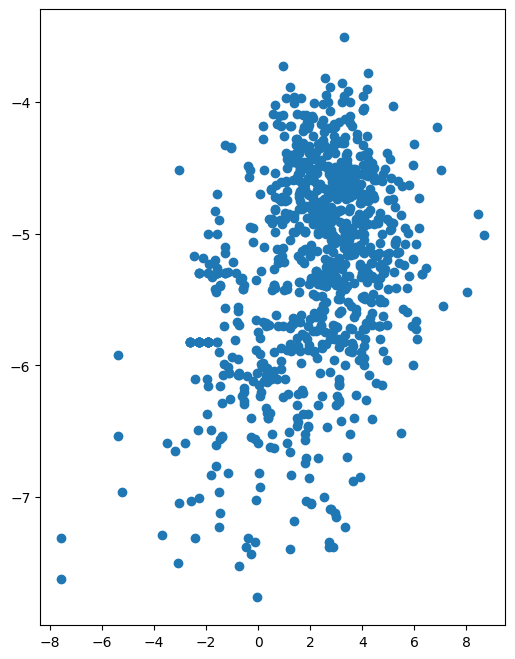

In [36]:
plt.figure(figsize=(6,8))
plt.plot(clean_df.MolLogP,clean_df.Y,
         'o')
plt.show()

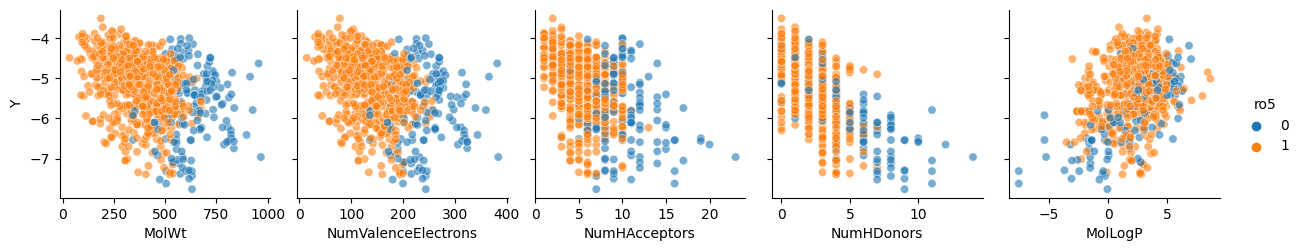

In [37]:
sns.pairplot(data = clean_df,
                x_vars = ['MolWt', 'NumValenceElectrons', 
                              'NumHAcceptors', 'NumHDonors', 'MolLogP'],
                y_vars = ['Y'],
                hue='ro5',
                plot_kws = {'alpha':.6})

plt.show()

In [38]:
X = drugs
X.head(1)

Drug_ID                                     Drug     Y  \
0  (-)-epicatechin  Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2 -6.22   

                                           Molecule  ro5  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f429cffe1f0>    1   

                                         descriptors  MaxAbsEStateIndex  \
0  [[8.856970427059712, 8.856970427059712, 0.8900...            8.85697   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  ...  fr_sulfide  \
0         8.85697           0.890041       -3.607962  ...         0.0   

   fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  \
0           0.0         0.0                0.0           0.0          0.0   

   fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0          0.0           0.0               0.0      0.0  

[1 rows x 215 columns]

In [39]:
X = X.drop(columns=['Drug_ID','Drug','Molecule','descriptors'])
X.head(1)

Y  ro5  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
0 -6.22    1            8.85697         8.85697           0.890041   

   MinEStateIndex       qed    MolWt  HeavyAtomMolWt  ExactMolWt  ...  \
0       -3.607962  0.509593  290.271         276.159  290.079038  ...   

   fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0         0.0           0.0         0.0                0.0           0.0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0          0.0          0.0           0.0               0.0      0.0  

[1 rows x 211 columns]

In [40]:
X_fea = X.iloc[:,2:]

In [41]:
X_fea.head(1)

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0            8.85697         8.85697           0.890041       -3.607962   

        qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0  0.509593  290.271         276.159  290.079038                110.0   

   NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                  0.0  ...         0.0           0.0         0.0   

   fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                0.0           0.0          0.0          0.0           0.0   

   fr_unbrch_alkane  fr_urea  
0               0.0      0.0  

[1 rows x 209 columns]

In [42]:
X['ro5']

0      1
1      1
2      1
3      1
4      1
      ..
905    1
906    1
907    0
908    0
909    1
Name: ro5, Length: 910, dtype: int64

In [43]:
y = X['ro5']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: ro5, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_fea, y,  
                                   random_state=414,
                                   stratify=y,
                                   test_size=.2)
print(y_train.value_counts())
print(y_test.value_counts())

1    610
0    118
Name: ro5, dtype: int64
1    153
0     29
Name: ro5, dtype: int64


In [45]:
X_train.head()

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
898          10.322064       10.322064           0.524619       -5.207921   
211          15.157321       15.157321           2.293131       -5.609596   
588          13.607631       13.607631           0.058428       -5.196121   
355          14.892046       14.892046           0.629422       -6.878986   
617          12.287882       12.287882           0.179374       -3.533069   

          qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
898  0.457868  514.722         472.386  514.353243                202.0   
211  0.785692  360.450         332.226  360.193674                142.0   
588  0.494073  535.670         502.406  535.225326                200.0   
355  0.250316  522.627         492.387  522.193691                194.0   
617  0.799428  235.239         222.135  235.084458                 90.0   

     NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
898                  0.0  ...         0.0           0.0         0.0   
211                  0.0  ...         0.0           0.0         0.0   
588                  0.0  ...         0.0           0.0         0.0   
355                  0.0  ...         0.0           1.0         0.0   
617                  0.0  ...         0.0           0.0         0.0   

     fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
898                0.0           1.0          0.0          0.0           0.0   
211                0.0           0.0          0.0          0.0           0.0   
588                0.0           0.0          0.0          0.0           0.0   
355                0.0           0.0          0.0          0.0           0.0   
617                0.0           0.0          0.0          0.0           0.0   

     fr_unbrch_alkane  fr_urea  
898               0.0      0.0  
211               0.0      0.0  
588               0.0      0.0  
355               0.0      0.0  
617               0.0      0.0  

[5 rows x 209 columns]

In [46]:
X_test.head()

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
882          14.609118       14.609118           1.160198       -4.769527   
242          14.022235       14.022235           0.909994       -6.483747   
319          15.001012       15.001012           0.536582       -5.871354   
480          14.891985       14.891985           0.551158       -6.216468   
393          16.717400       16.717400           0.629090       -6.710539   

          qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
882  0.312961  450.396         428.220  450.116212                172.0   
242  0.560412  430.379         416.267  430.061041                154.0   
319  0.373567  608.688         568.368  608.273381                236.0   
480  0.538190  434.453         415.301  434.117252                158.0   
393  0.109755  820.992         764.544  820.427196                318.0   

     NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
882                  0.0  ...         0.0           0.0         0.0   
242                  0.0  ...         0.0           0.0         1.0   
319                  0.0  ...         0.0           0.0         0.0   
480                  0.0  ...         0.0           0.0         0.0   
393                  0.0  ...         0.0           0.0         0.0   

     fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
882                0.0           0.0          0.0          0.0           0.0   
242                0.0           0.0          0.0          0.0           0.0   
319                0.0           0.0          0.0          0.0           0.0   
480                0.0           0.0          0.0          0.0           0.0   
393                0.0           0.0          0.0          0.0           0.0   

     fr_unbrch_alkane  fr_urea  
882               0.0      0.0  
242               0.0      0.0  
319               0.0      0.0  
480               0.0      1.0  
393               0.0      0.0  

[5 rows x 209 columns]

In [47]:
y_train.head()

898    1
211    1
588    1
355    1
617    1
Name: ro5, dtype: int64

In [48]:
y_test.head()

882    0
242    1
319    0
480    1
393    0
Name: ro5, dtype: int64

In [49]:
len(X_train)

728

In [50]:
X_train[X_train.isnull().any(axis=1)]

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
91           13.15109        13.15109                0.0       -3.578285   

         qed   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
91  0.366873  295.27         281.158  295.082052                104.0   

    NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
91                  0.0  ...         0.0           0.0         0.0   

    fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
91                0.0           0.0          0.0          0.0           0.0   

    fr_unbrch_alkane  fr_urea  
91               0.0      0.0  

[1 rows x 209 columns]

In [51]:
X_train = X_train.drop(91)

In [52]:
len(X_train)

727

In [53]:
for des in des_keys:
  print(X_train[des].isna().value_counts())

False    727
Name: MaxAbsEStateIndex, dtype: int64
False    727
Name: MaxEStateIndex, dtype: int64
False    727
Name: MinAbsEStateIndex, dtype: int64
False    727
Name: MinEStateIndex, dtype: int64
False    727
Name: qed, dtype: int64
False    727
Name: MolWt, dtype: int64
False    727
Name: HeavyAtomMolWt, dtype: int64
False    727
Name: ExactMolWt, dtype: int64
False    727
Name: NumValenceElectrons, dtype: int64
False    727
Name: NumRadicalElectrons, dtype: int64
False    727
Name: MaxPartialCharge, dtype: int64
False    727
Name: MinPartialCharge, dtype: int64
False    727
Name: MaxAbsPartialCharge, dtype: int64
False    727
Name: MinAbsPartialCharge, dtype: int64
False    727
Name: FpDensityMorgan1, dtype: int64
False    727
Name: FpDensityMorgan2, dtype: int64
False    727
Name: FpDensityMorgan3, dtype: int64
False    727
Name: BCUT2D_MWHI, dtype: int64
False    727
Name: BCUT2D_MWLOW, dtype: int64
False    727
Name: BCUT2D_CHGHI, dtype: int64
False    727
Name: BCUT2D_CHGLO, dt

In [54]:
# Let's do the same for y_train, X_test, and y_test

In [55]:
# y_train
y_train = y_train.drop(91)
print(len(y_train))

727


In [56]:
# Now for the test set:
X_test[X_test.isnull().any(axis=1)]

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
102          11.559838       11.559838                0.0       -3.656906   

          qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
102  0.638394  252.245         239.141  252.076239                 88.0   

     NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
102                  0.0  ...         0.0           0.0         0.0   

     fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
102                0.0           0.0          0.0          0.0           0.0   

     fr_unbrch_alkane  fr_urea  
102               0.0      0.0  

[1 rows x 209 columns]

In [57]:
# Remove entry 102! 
print(len(X_test))
X_test = X_test.drop(102)
y_test = y_test.drop(102)
print(len(y_test))

182
181


In [58]:
for des in des_keys:
  print(X_test[des].isna().value_counts())

False    181
Name: MaxAbsEStateIndex, dtype: int64
False    181
Name: MaxEStateIndex, dtype: int64
False    181
Name: MinAbsEStateIndex, dtype: int64
False    181
Name: MinEStateIndex, dtype: int64
False    181
Name: qed, dtype: int64
False    181
Name: MolWt, dtype: int64
False    181
Name: HeavyAtomMolWt, dtype: int64
False    181
Name: ExactMolWt, dtype: int64
False    181
Name: NumValenceElectrons, dtype: int64
False    181
Name: NumRadicalElectrons, dtype: int64
False    181
Name: MaxPartialCharge, dtype: int64
False    181
Name: MinPartialCharge, dtype: int64
False    181
Name: MaxAbsPartialCharge, dtype: int64
False    181
Name: MinAbsPartialCharge, dtype: int64
False    181
Name: FpDensityMorgan1, dtype: int64
False    181
Name: FpDensityMorgan2, dtype: int64
False    181
Name: FpDensityMorgan3, dtype: int64
False    181
Name: BCUT2D_MWHI, dtype: int64
False    181
Name: BCUT2D_MWLOW, dtype: int64
False    181
Name: BCUT2D_CHGHI, dtype: int64
False    181
Name: BCUT2D_CHGLO, dt

In [59]:
# Now there should be no NAN values in the DataFrame 

In [60]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [61]:
scaler = StandardScaler()

In [62]:
X_train = scaler.fit_transform(X_train)

In [63]:
X_test = scaler.transform(X_test)

In [64]:
rf = RandomForestClassifier(100, 
                            max_depth = 3, 
                            random_state = 614,
                            max_samples = 80)  

In [65]:
des_keys

dict_keys(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10',

In [66]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_samples=80, random_state=614)

In [67]:
rf_preds = rf.predict(X_test)

In [68]:
rf_preds

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1])

In [69]:
rf.feature_importances_

array([0.00468526, 0.00287952, 0.0029879 , 0.00180148, 0.04462267,
       0.05723384, 0.05604516, 0.05603402, 0.03296327, 0.        ,
       0.00217254, 0.0019171 , 0.00529337, 0.00266755, 0.00098039,
       0.00032801, 0.00179629, 0.00079063, 0.00215155, 0.00161515,
       0.00159459, 0.        , 0.00507541, 0.00225512, 0.00078431,
       0.00348667, 0.00516484, 0.02728247, 0.01787976, 0.00224777,
       0.01482813, 0.02079295, 0.00596792, 0.01905338, 0.03089408,
       0.00916254, 0.00459319, 0.00698175, 0.02983994, 0.00762723,
       0.01021112, 0.        , 0.01609557, 0.00966584, 0.00215546,
       0.03164774, 0.0146217 , 0.01396598, 0.00177458, 0.00237133,
       0.00260366, 0.        , 0.        , 0.        , 0.00032407,
       0.00438149, 0.00281437, 0.00665617, 0.00162567, 0.00150322,
       0.04034633, 0.00093595, 0.00593827, 0.00588963, 0.        ,
       0.00369043, 0.        , 0.00070897, 0.        , 0.01166041,
       0.        , 0.00058797, 0.00263856, 0.00151152, 0.00082

In [70]:
np.argmax(rf.feature_importances_)

5

In [71]:
# This is MolWt

In [72]:
rf.feature_importances_[5]

0.05723383914876099

In [73]:
rf.feature_importances_

array([0.00468526, 0.00287952, 0.0029879 , 0.00180148, 0.04462267,
       0.05723384, 0.05604516, 0.05603402, 0.03296327, 0.        ,
       0.00217254, 0.0019171 , 0.00529337, 0.00266755, 0.00098039,
       0.00032801, 0.00179629, 0.00079063, 0.00215155, 0.00161515,
       0.00159459, 0.        , 0.00507541, 0.00225512, 0.00078431,
       0.00348667, 0.00516484, 0.02728247, 0.01787976, 0.00224777,
       0.01482813, 0.02079295, 0.00596792, 0.01905338, 0.03089408,
       0.00916254, 0.00459319, 0.00698175, 0.02983994, 0.00762723,
       0.01021112, 0.        , 0.01609557, 0.00966584, 0.00215546,
       0.03164774, 0.0146217 , 0.01396598, 0.00177458, 0.00237133,
       0.00260366, 0.        , 0.        , 0.        , 0.00032407,
       0.00438149, 0.00281437, 0.00665617, 0.00162567, 0.00150322,
       0.04034633, 0.00093595, 0.00593827, 0.00588963, 0.        ,
       0.00369043, 0.        , 0.00070897, 0.        , 0.01166041,
       0.        , 0.00058797, 0.00263856, 0.00151152, 0.00082

In [74]:
idxs = []
for i, imp in enumerate(rf.feature_importances_):
  if imp > 0.04:
    idxs.append(i)

print(idxs)

[4, 5, 6, 7, 60]


In [75]:
from sklearn.metrics import roc_curve
fprs,tprs,cutoffs = roc_curve(y_test, rf_preds)
print(fprs)
print(tprs)

[0.         0.27586207 1.        ]
[0.         0.98684211 1.        ]
